# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_competition_extention'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
import utilities.helper
import sleap.process_pose

In [7]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

# Functions

In [8]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [9]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [10]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [11]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [12]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

## Inputs & Data

Explanation of each input and where it comes from.

In [13]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1

LFP_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_2_03_spectral_bands.pkl")
LFP_SPECTRAL_DF["video_name"] = LFP_SPECTRAL_DF["video_name"].apply(lambda x: x.strip(".videoTimeStamps.cameraHWSync"))

# SLEAP_DIR = os.path.join(git_root, "proc/sleap") 
# SLEAP_DIR = "/scratch/back_up/reward_competition_extention/final_proc/id_corrected"
SLEAP_DIR = "/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected"

OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
WINDOW_SIZE = 25
DISTANCE_THRESHOLD = 2

In [14]:
START_STOP_FRAME_DF = pd.read_excel("./data/rce_per_subject_start_stop_video_frame.xlsx")


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [15]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

In [16]:
FULL_LFP_TRACES_PKL = "{}_04_spectral_and_sleap.pkl".format(OUTPUT_PREFIX)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

# Getting the videos where the subject is in the recording

### Looking at when each subject was in each video

In [17]:
START_STOP_FRAME_DF = pd.read_excel("./data/rce_per_subject_start_stop_video_frame.xlsx")
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["file_path"])

- Getting the name of the SLEAP and video files where each subject was in

In [18]:
START_STOP_FRAME_DF["sleap_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: os.path.basename(x))
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
START_STOP_FRAME_DF["start_frame"] = START_STOP_FRAME_DF["start_frame"].astype(int)
START_STOP_FRAME_DF["stop_frame"] = START_STOP_FRAME_DF["stop_frame"].astype(int)

In [19]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(columns=["file_path", "notes"], errors="ignore")

In [20]:
START_STOP_FRAME_DF["video_name"].unique()

array(['20221214_125409_om_and_comp_6_1_and_6_3.1',
       '20221215_145401_comp_amd_om_6_1_and_6_3.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.1',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_and_1-2.2',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '

In [21]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name
0,1,25000,6.3,6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...,20221214_125409_om_and_comp_6_1_and_6_3.1
1,27500,73600,6.1_6.3,6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1
2,51500,76454,6.3,6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1
3,1,48500,6.1_6.3,6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.2_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1
4,32700,68257,1.2,1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...


- Splitting each row into seperate row for each subject in the video

In [22]:
START_STOP_FRAME_DF["tracked_subject"] = START_STOP_FRAME_DF["tracked_subject"].apply(lambda x: str(x).split("_"))
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"]

In [23]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.explode("current_subject")

In [24]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject
0,1,25000,[6.3],6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.1_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.3
1,27500,73600,"[6.1, 6.3]",6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.1
1,27500,73600,"[6.1, 6.3]",6.1_6.3,1,20221214_125409_om_and_comp_6_1_and_6_3.1.2_su...,20221214_125409_om_and_comp_6_1_and_6_3.1,6.3
2,51500,76454,[6.3],6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.1_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1,6.3
3,1,48500,"[6.1, 6.3]",6.1_6.3,1,20221215_145401_comp_amd_om_6_1_and_6_3.1.2_su...,20221215_145401_comp_amd_om_6_1_and_6_3.1,6.1


In [25]:
START_STOP_FRAME_DF.shape

(79, 8)

# Reading in the h5 files between recordings

In [26]:
START_STOP_FRAME_DF["sleap_glob"] = START_STOP_FRAME_DF["sleap_name"].apply(lambda x: glob.glob(os.path.join(SLEAP_DIR, "**", x)))


In [27]:
for name in START_STOP_FRAME_DF[START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: len(x) == 0)]["sleap_name"]:
    print(name)

20221214_125409_om_and_comp_6_1_and_6_3.1.1_subj.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.2_subj.id_corrected.h5
20221214_125409_om_and_comp_6_1_and_6_3.1.2_subj.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.1_subj.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.2_subj.id_corrected.h5
20221215_145401_comp_amd_om_6_1_and_6_3.1.2_subj.id_corrected.h5


In [28]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF['sleap_glob'].apply(lambda x: len(x) >= 1)]
START_STOP_FRAME_DF = START_STOP_FRAME_DF.reset_index(drop=True)




In [29]:
START_STOP_FRAME_DF["sleap_path"] = START_STOP_FRAME_DF["sleap_glob"].apply(lambda x: x[0])

In [30]:
START_STOP_FRAME_DF["all_sleap_data"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.extract_sleap_data(x))


In [31]:
START_STOP_FRAME_DF["body_parts"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [32]:
START_STOP_FRAME_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [33]:
START_STOP_FRAME_DF["locations"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [34]:
START_STOP_FRAME_DF["track_names"] = START_STOP_FRAME_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [35]:
START_STOP_FRAME_DF["locations"].iloc[0].shape

(68258, 6, 2, 1)

In [36]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names
0,32700,68257,[1.2],1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[244.3555603 ] [395.80090332...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[244.3555603], [395.80090332]], [[247.78367...",[1.2]
1,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]"
2,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]"
3,33000,68212,[1.1],1.1_1.2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,"{'locations': [[[[nan] [nan]], [[nan] [nan]]...","[left_ear, right_ear, nose, tail_base, thorax,...","[[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...",[1.1]
4,33400,68332,[1.1],1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[336.33197021] [400.23355103...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[336.33197021], [400.23355103]], [[319.3523...",[1.1]


In [37]:
# Getting the indexes of each subject from the track list
START_STOP_FRAME_DF["subject_to_index"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["tracked_subject"] if k in x["track_names"]}, axis=1)

In [38]:
START_STOP_FRAME_DF["subject_to_index"].head()

0              {'1.2': 0}
1    {'1.1': 0, '1.2': 1}
2    {'1.1': 0, '1.2': 1}
3              {'1.1': 0}
4              {'1.1': 0}
Name: subject_to_index, dtype: object

In [39]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [40]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [41]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.2': [[[244.3555603  395.80090332], [247.78...
1    {'1.1': [[[331.99508667 127.74658203], [307.31...
2    {'1.1': [[[331.99508667 127.74658203], [307.31...
3    {'1.1': [[[nan nan], [nan nan], [nan nan], [na...
4    {'1.1': [[[336.33197021 400.23355103], [319.35...
Name: subject_to_tracks, dtype: object

In [42]:
START_STOP_FRAME_DF["subject_to_tracks"].apply(lambda x: x.keys()).head()

0         (1.2)
1    (1.1, 1.2)
2    (1.1, 1.2)
3         (1.1)
4         (1.1)
Name: subject_to_tracks, dtype: object

In [43]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,all_sleap_data,body_parts,locations,track_names,subject_to_index,subject_to_tracks
0,32700,68257,[1.2],1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[244.3555603 ] [395.80090332...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[244.3555603], [395.80090332]], [[247.78367...",[1.2],{'1.2': 0},"{'1.2': [[[244.3555603 395.80090332], [247.78..."
1,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[331.99508667 127.74658203], [307.31..."
2,1,32300,"[1.1, 1.2]",1.1_1.2,1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[331.99508667 244.3555603 ] ...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[331.99508667 244.3555603 ], [127.74658203 ...","[1.1, 1.2]","{'1.1': 0, '1.2': 1}","{'1.1': [[[331.99508667 127.74658203], [307.31..."
3,33000,68212,[1.1],1.1_1.2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,"{'locations': [[[[nan] [nan]], [[nan] [nan]]...","[left_ear, right_ear, nose, tail_base, thorax,...","[[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...",[1.1],{'1.1': 0},"{'1.1': [[[nan nan], [nan nan], [nan nan], [na..."
4,33400,68332,[1.1],1.1_1.4,1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,{'locations': [[[[336.33197021] [400.23355103...,"[left_ear, right_ear, nose, tail_base, thorax,...","[[[[336.33197021], [400.23355103]], [[319.3523...",[1.1],{'1.1': 0},"{'1.1': [[[336.33197021 400.23355103], [319.35..."


## Getting the coordinates of the corners

In [44]:
START_STOP_FRAME_DF["sleap_path"].iloc[0]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.1_subj.id_corrected.h5'

In [45]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
START_STOP_FRAME_DF["corner_path"] = START_STOP_FRAME_DF["sleap_path"].apply(lambda x: x.replace("id_corrected.h5", "corner.h5").replace(".fixed", "").replace(".round_1", "").replace(".1_subj", "").replace(".2_subj", ""))


In [46]:
START_STOP_FRAME_DF["corner_path"].iloc[0]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.corner.h5'

In [47]:
# Getting the indexes of each corner location
START_STOP_FRAME_DF["corner_parts"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_node_names_from_sleap(x))

In [48]:
START_STOP_FRAME_DF["video_name"].iloc[26]

'20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.3'

In [49]:
START_STOP_FRAME_DF["corner_parts"]

0     [box_top_left, box_top_right, reward_port, box...
1     [box_top_left, box_top_right, reward_port, box...
2     [box_top_left, box_top_right, reward_port, box...
3     [box_bottom_left, box_top_right, reward_port, ...
4     [box_bottom_left, box_top_right, reward_port, ...
                            ...                        
68    [box_bottom_left, reward_port, box_top_right, ...
69    [box_bottom_left, reward_port, box_top_right, ...
70    [box_bottom_left, reward_port, box_top_right, ...
71    [box_bottom_left, reward_port, box_top_right, ...
72    [box_bottom_left, reward_port, box_top_right, ...
Name: corner_parts, Length: 73, dtype: object

In [50]:
# TODO: Remove this once corner files are fixed
START_STOP_FRAME_DF = START_STOP_FRAME_DF[START_STOP_FRAME_DF["corner_parts"].apply(lambda x: "reward_port" in x)]

In [51]:
# Getting the coordinates of all the corners
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF["corner_path"].apply(lambda x: sleap.process_pose.get_sleap_tracks_from_h5(x))

In [52]:
# Parsing out each corner and creating a dictionary of name to coordinates
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [53]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
1     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
2     {'box_top_left': [[[nan], [nan]], [[nan], [nan...
3     {'box_bottom_left': [[[234.69934175], [389.572...
4     {'box_bottom_left': [[[219.49634883], [382.936...
                            ...                        
68    {'box_bottom_left': [[[216.16270965], [386.158...
69    {'box_bottom_left': [[[230.39644068], [395.236...
70    {'box_bottom_left': [[[230.39644068], [395.236...
71    {'box_bottom_left': [[[230.39644068], [395.236...
72    {'box_bottom_left': [[[230.39644068], [395.236...
Name: corner_to_coordinate, Length: 73, dtype: object

In [54]:
# Filtering out all the Nans because there's only one labeled frame
START_STOP_FRAME_DF["corner_to_coordinate"] = START_STOP_FRAME_DF.apply(lambda x: {k: v[~np.isnan(v)][:2] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [55]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_top_left': [215.09666220678088, 113.9234...
3     {'box_bottom_left': [234.69934174733294, 389.5...
4     {'box_bottom_left': [219.49634882813532, 382.9...
                            ...                        
68    {'box_bottom_left': [216.16270964603552, 386.1...
69    {'box_bottom_left': [230.39644068293484, 395.2...
70    {'box_bottom_left': [230.39644068293484, 395.2...
71    {'box_bottom_left': [230.39644068293484, 395.2...
72    {'box_bottom_left': [230.39644068293484, 395.2...
Name: corner_to_coordinate, Length: 73, dtype: object

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [56]:
# Using the x-coordinates for the width
START_STOP_FRAME_DF["bottom_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
START_STOP_FRAME_DF["top_width"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [57]:
# Using the y-coordinates for the height
START_STOP_FRAME_DF["right_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
START_STOP_FRAME_DF["left_height"] = START_STOP_FRAME_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [58]:
# averaging the width and height by adding both sides and then getting the mean
START_STOP_FRAME_DF["average_height"] = START_STOP_FRAME_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
START_STOP_FRAME_DF["average_width"] = START_STOP_FRAME_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [59]:
START_STOP_FRAME_DF["width_ratio"] = MED_PC_WIDTH / START_STOP_FRAME_DF["average_width"]
START_STOP_FRAME_DF["height_ratio"] = MED_PC_HEIGHT / START_STOP_FRAME_DF["average_height"]

In [60]:
START_STOP_FRAME_DF["height_ratio"]

0     0.089984
1     0.089984
2     0.089984
3     0.091411
4     0.091180
        ...   
68    0.092148
69    0.090235
70    0.090235
71    0.090235
72    0.090235
Name: height_ratio, Length: 73, dtype: float64

In [61]:
START_STOP_FRAME_DF["width_ratio"]

0     0.140631
1     0.140631
2     0.140631
3     0.141259
4     0.138909
        ...   
68    0.137797
69    0.136504
70    0.136504
71    0.136504
72    0.136504
Name: width_ratio, Length: 73, dtype: float64

## Converting Pixels to cm

In [62]:
START_STOP_FRAME_DF["in_video_subjects"] = START_STOP_FRAME_DF["in_video_subjects"].apply(lambda x: x.split("_"))

In [63]:
START_STOP_FRAME_DF["subject_to_tracks"] = START_STOP_FRAME_DF.apply(lambda x: {k: v for k, v in x["subject_to_tracks"].items() if k in x["in_video_subjects"]}, axis=1)

- Converting the X-dimension

In [64]:
START_STOP_FRAME_DF["subject_to_tracks"].head()

0    {'1.2': [[[244.3555603  395.80090332], [247.78...
1    {'1.1': [[[331.99508667 127.74658203], [307.31...
2    {'1.1': [[[331.99508667 127.74658203], [307.31...
3    {'1.1': [[[nan nan], [nan nan], [nan nan], [na...
4    {'1.1': [[[336.33197021 400.23355103], [319.35...
Name: subject_to_tracks, dtype: object

In [65]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.fill_missing(sleap.process_pose.rescale_dimension_in_array(value, dimension=0, ratio=x["width_ratio"])) for key, value in x["subject_to_tracks"].items()}, axis=1)

- Converting the Y-dimension

In [66]:
START_STOP_FRAME_DF["rescaled_locations"] = START_STOP_FRAME_DF.apply(lambda x: {key: sleap.process_pose.rescale_dimension_in_array(value, dimension=1, ratio=x["height_ratio"]) for key, value in x["rescaled_locations"].items()}, axis=1)

In [67]:
START_STOP_FRAME_DF["corner_to_coordinate"]

0     {'box_top_left': [215.09666220678088, 113.9234...
1     {'box_top_left': [215.09666220678088, 113.9234...
2     {'box_top_left': [215.09666220678088, 113.9234...
3     {'box_bottom_left': [234.69934174733294, 389.5...
4     {'box_bottom_left': [219.49634882813532, 382.9...
                            ...                        
68    {'box_bottom_left': [216.16270964603552, 386.1...
69    {'box_bottom_left': [230.39644068293484, 395.2...
70    {'box_bottom_left': [230.39644068293484, 395.2...
71    {'box_bottom_left': [230.39644068293484, 395.2...
72    {'box_bottom_left': [230.39644068293484, 395.2...
Name: corner_to_coordinate, Length: 73, dtype: object

In [68]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,corner_to_coordinate,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio,rescaled_locations
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[34.36404037 35.61555332], [34.84614..."
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,"{'box_top_left': [215.09666220678088, 113.9234...",209.287764,210.248994,267.077370,266.353718,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778..."
3,33000,68212,[1.1],"[1.1, 1.2]",2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,"{'box_bottom_left': [234.69934174733294, 389.5...",208.478033,209.193827,262.966281,262.136905,262.551593,208.835930,0.141259,0.091411,"{'1.1': [[[27.67316905 31.06298795], [27.08155..."
4,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,"{'box_bottom_left': [219.49634882813532, 382.9...",213.213618,211.523940,263.471488,262.958532,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101..."


In [69]:
# Normalize dictionary column
normalized = pd.json_normalize(START_STOP_FRAME_DF["corner_to_coordinate"])

In [70]:
normalized.head()

,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,"[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
3,"[238.18599786891832, 127.43516499865694]","[447.3798248244432, 127.79519761339816]","[339.93931931458565, 407.66117323379024]","[234.69934174733294, 389.57206997722295]","[443.1773751472956, 390.7614781634938]"
4,"[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"


In [71]:


# Drop the original column and concat the normalized DataFrame
START_STOP_FRAME_DF = pd.concat([START_STOP_FRAME_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [72]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[34.36404037 35.61555332], [34.84614...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[215.09666220678088, 113.92341627572542]","[425.345655727638, 112.2488439777975]","[321.6525529313325, 398.276176488323]","[216.58701461395228, 380.2771341993332]","[425.874778248961, 379.32621417226574]"
3,33000,68212,[1.1],"[1.1, 1.2]",2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,262.551593,208.835930,0.141259,0.091411,"{'1.1': [[[27.67316905 31.06298795], [27.08155...","[238.18599786891832, 127.43516499865694]","[447.3798248244432, 127.79519761339816]","[339.93931931458565, 407.66117323379024]","[234.69934174733294, 389.57206997722295]","[443.1773751472956, 390.7614781634938]"
4,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[211.8445364825192, 119.97841708068698]","[423.3684762341395, 112.2997417613741]","[326.19769332642636, 399.0248601049142]","[219.49634882813532, 382.9369493804368]","[432.7099664053751, 375.77122988087467]"


In [73]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset=["reward_port"])

- Converting the corner coordinates into cms

In [74]:
for corner in START_STOP_FRAME_DF["corner_parts"].iloc[0]:
    START_STOP_FRAME_DF[corner] = START_STOP_FRAME_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [75]:
FILE_INDEX = 0

In [76]:
START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX]

'/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/id_corrected/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1/20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1.1_subj.id_corrected.h5'

In [77]:
START_STOP_FRAME_DF["rescaled_locations"].head()

0    {'1.2': [[[34.36404037 35.61555332], [34.84614...
1    {'1.1': [[[46.68890098 11.49508545], [43.21778...
2    {'1.1': [[[46.68890098 11.49508545], [43.21778...
3    {'1.1': [[[27.67316905 31.06298795], [27.08155...
4    {'1.1': [[[46.71964111 36.49337937], [44.36101...
Name: rescaled_locations, dtype: object

In [78]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'sleap_glob', 'sleap_path', 'all_sleap_data', 'body_parts', 'locations',
       'track_names', 'subject_to_index', 'subject_to_tracks', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_top_left', 'box_top_right',
       'reward_port', 'box_bottom_left', 'box_bottom_right'],
      dtype='object')

In [79]:
with h5py.File(START_STOP_FRAME_DF["sleap_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    current_subject = START_STOP_FRAME_DF["current_subject"].iloc[FILE_INDEX]
    locations = START_STOP_FRAME_DF["rescaled_locations"].iloc[FILE_INDEX][current_subject]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68258, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [80]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

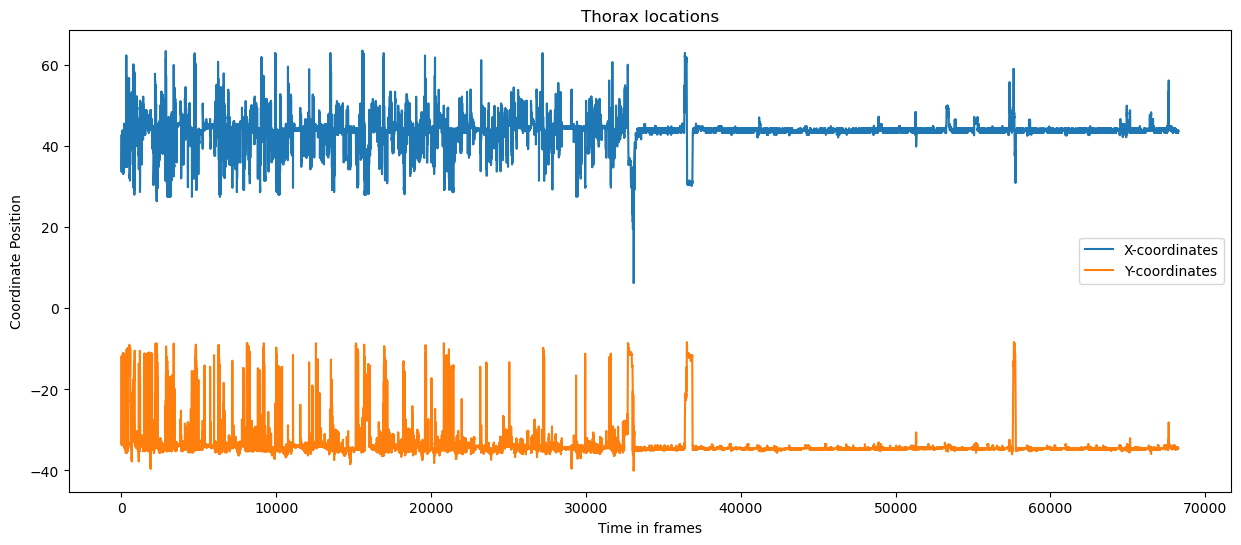

In [81]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

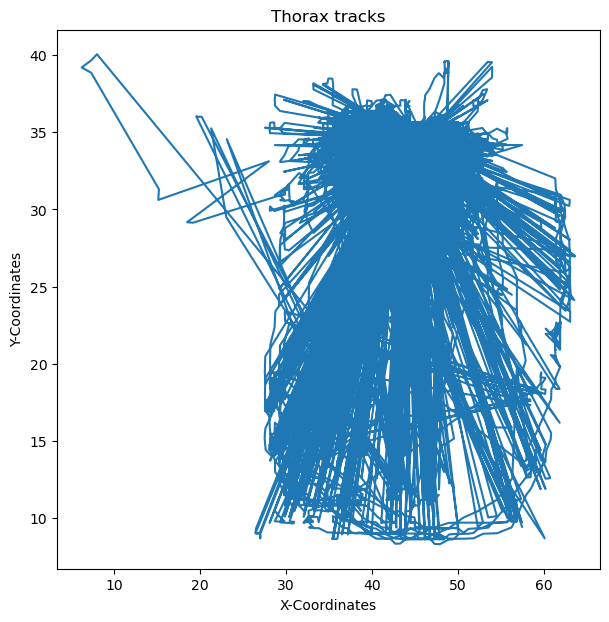

In [82]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


## Creating an individual column for each pose tracking

In [83]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.dropna(subset="current_subject")

In [84]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_height,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.2': [[[34.36404037 35.61555332], [34.84614...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,266.715544,209.768379,0.140631,0.089984,"{'1.1': [[[46.68890098 11.49508545], [43.21778...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]"
3,33000,68212,[1.1],"[1.1, 1.2]",2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,262.551593,208.835930,0.141259,0.091411,"{'1.1': [[[27.67316905 31.06298795], [27.08155...","[33.645967583991556, 11.648925560748966]","[63.19652380262479, 11.681836359966798]","[48.01956210909252, 37.264554576109816]","[33.1534452699471, 35.61101869926864]","[62.60288905131385, 35.71974322144712]"
4,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,263.215010,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]"


In [85]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF.apply(lambda x: list((set(x["tracked_subject"]) - set([x["current_subject"]]))), axis=1)

In [86]:
START_STOP_FRAME_DF[START_STOP_FRAME_DF["agent"].apply(lambda x: len(x) != 1)]

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,sleap_glob,sleap_path,...,average_width,width_ratio,height_ratio,rescaled_locations,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,209.768379,0.140631,0.089984,"{'1.2': [[[34.36404037 35.61555332], [34.84614...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",[]
3,33000,68212,[1.1],"[1.1, 1.2]",2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,208.835930,0.141259,0.091411,"{'1.1': [[[27.67316905 31.06298795], [27.08155...","[33.645967583991556, 11.648925560748966]","[63.19652380262479, 11.681836359966798]","[48.01956210909252, 37.264554576109816]","[33.1534452699471, 35.61101869926864]","[62.60288905131385, 35.71974322144712]",[]
4,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,212.368779,0.138909,0.091180,"{'1.1': [[[46.71964111 36.49337937], [44.36101...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",[]
7,33700,68292,[1.4],"[1.1, 1.4]",2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.4,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,208.236715,0.141666,0.091178,"{'1.4': [[[26.62764591 30.65273206], [26.64060...","[33.5247551649501, 11.635870119339435]","[63.29822206480314, 11.564044115144247]","[48.142377889356574, 37.337926404692936]","[33.21678486532013, 35.325921663442216]","[62.44331796546709, 35.87399257104147]",[]
8,32800,44205,[1.1],"[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,212.714155,0.138684,0.091993,"{'1.1': [[[52.75681022 36.78031944], [52.13143...","[29.10707058981441, 11.364487226798616]","[58.883863567261514, 10.806271116252097]","[45.44232917370965, 36.91440422283628]","[30.339373669373565, 35.17083382117832]","[59.562580691926456, 34.99992452187238]",[]
11,41600,75829,[1.2],"[1.1, 1.2]",2,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.2,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,209.899717,0.140543,0.091213,"{'1.2': [[[28.66627067 2.13697306], [ 9.52213...","[33.39476994396835, 11.628846604390953]","[62.97669267964438, 11.673212770394656]","[48.149571057861564, 37.42853283171967]","[32.956534544878494, 35.30124761187179]","[62.37461180920246, 36.00081176291383]",[]
12,1,23574,[1.1],"[1.1, 1.2]",1,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,1.1,[/blue/npadillacoreano/ryoi360/projects/reward...,/blue/npadillacoreano/ryoi360/projects/reward_...,...,210.920670,0.139863,0.091459,"{'1.1': [[[46.36973988 35.49525096], [43.13241...","[29.253482928127013, 11.47363698436633]","[58.934080713694, 10.340666947239828]","[45.88048811411714, 36.6313847000801]","[30.697870470510356, 35.001319517779145]","[60.01727268494337, 34.812984

In [87]:
START_STOP_FRAME_DF["agent"] = START_STOP_FRAME_DF["agent"].apply(lambda x: x[0] if len(x) == 1 else None)

In [88]:
START_STOP_FRAME_DF["subject_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"][x["current_subject"]] , axis=1)

In [89]:
START_STOP_FRAME_DF["agent_locations"] = START_STOP_FRAME_DF.apply(lambda x: x["rescaled_locations"].get(x["agent"], np.nan) if x["agent"] else np.nan, axis=1)

## Removing unnecessary columns

In [90]:
START_STOP_FRAME_DF = START_STOP_FRAME_DF.drop(["sleap_glob", "subject_to_index", "subject_to_tracks", "corner_parts", "corner_to_coordinate", "bottom_width", "top_width", "right_height", "left_height", "average_height", "average_width", "width_ratio", "height_ratio", 'locations', 'track_names', 'sleap_path', 'corner_path', 'all_sleap_data', 'rescaled_locations'], errors="ignore", axis=1)

In [91]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations'],
      dtype='object')

In [92]:
START_STOP_FRAME_DF.head()

,start_frame,stop_frame,tracked_subject,in_video_subjects,box_number,sleap_name,video_name,current_subject,body_parts,box_top_left,box_top_right,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations
0,32700,68257,[1.2],"[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",None,"[[[34.36404036584844, 35.615553316175784], [34...",NaN
1,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34..."
2,1,32300,"[1.1, 1.2]","[1.1, 1.2]",1,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.2,"[left_ear, right_ear, nose, tail_base, thorax,...","[30.24932345912479, 10.25122851487125]","[59.816912963855586, 10.100544626940918]","[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43..."
3,33000,68212,[1.1],"[1.1, 1.2]",2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[33.645967583991556, 11.648925560748966]","[63.19652380262479, 11.681836359966798]","[48.01956210909252, 37.264554576109816]","[33.1534452699471, 35.61101869926864]","[62.60288905131385, 35.71974322144712]",None,"[[[27.67316905433137, 31.06298795228111], [27....",NaN
4,33400,68332,[1.1],"[1.1, 1.4]",1,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,1.1,"[left_ear, right_ear, nose, tail_base, thorax,...","[29.42717788149638, 10.939657307701639]","[58.80982189308497, 10.239514076824564]","[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",None,"[[[46.71964110607613, 36.493379374373234], [44...",NaN


# Calculate velocity

In [93]:
START_STOP_FRAME_DF.columns

Index(['start_frame', 'stop_frame', 'tracked_subject', 'in_video_subjects',
       'box_number', 'sleap_name', 'video_name', 'current_subject',
       'body_parts', 'box_top_left', 'box_top_right', 'reward_port',
       'box_bottom_left', 'box_bottom_right', 'agent', 'subject_locations',
       'agent_locations'],
      dtype='object')

In [94]:
START_STOP_FRAME_DF["body_parts"].apply(lambda x: x.index("thorax"))

0     4
1     4
2     4
3     4
4     4
     ..
68    4
69    4
70    4
71    4
72    4
Name: body_parts, Length: 73, dtype: int64

In [95]:
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["subject_locations"][:,x["body_parts"].index("thorax"),:], window_size=FRAME_RATE*3) * FRAME_RATE, axis=1)
START_STOP_FRAME_DF["subject_thorax_velocity"] = START_STOP_FRAME_DF["subject_thorax_velocity"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

In [96]:
START_STOP_FRAME_DF["agent_locations"]

0                                                   NaN
1     [[[34.36404036584844, 35.615553316175784], [34...
2     [[[46.68890098287189, 11.495085446056166], [43...
3                                                   NaN
4                                                   NaN
                            ...                        
68    [[[42.40523742457364, 29.11403633803355], [40....
69    [[[32.683056182830434, 34.92733973755609], [32...
70    [[[33.89056344526231, 13.30128534512865], [34....
71    [[[32.683056182830434, 34.92733973755609], [32...
72    [[[4.371455668449597, 33.21801163507191], [58....
Name: agent_locations, Length: 73, dtype: object

In [97]:
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF.apply(lambda x: compute_velocity(x["agent_locations"][:,x["body_parts"].index("thorax"),:], window_size=FRAME_RATE*3) * FRAME_RATE if x["agent_locations"] is not np.nan else np.nan, axis=1)
START_STOP_FRAME_DF["agent_thorax_velocity"] = START_STOP_FRAME_DF["agent_thorax_velocity"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)


In [98]:
START_STOP_FRAME_DF["subject_thorax_velocity"].iloc[0].shape

(68258,)

## Calculate distance to reward port

In [99]:
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["subject_locations"][:,x["body_parts"].index("thorax"),:] - x["reward_port"], axis=1),  axis=1)
START_STOP_FRAME_DF["subject_thorax_to_reward_port"] = START_STOP_FRAME_DF["subject_thorax_to_reward_port"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

In [100]:
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF.apply(lambda x: np.linalg.norm(x["agent_locations"][:,x["body_parts"].index("thorax"),:] - x["reward_port"], axis=1) if x["agent_locations"] is not np.nan else np.nan,  axis=1)
START_STOP_FRAME_DF["agent_thorax_to_reward_port"] = START_STOP_FRAME_DF["agent_thorax_to_reward_port"].apply(lambda x: x.astype(np.float16) if x is not np.nan else np.nan)

## Putting together LFP and video start/stop

In [101]:
START_STOP_FRAME_DF["video_name"].unique()[:5]

array(['20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.2',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1'],
      dtype=object)

In [102]:
LFP_SPECTRAL_DF["video_name"].unique()[:5]

array(['20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.1',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.1',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_and_1-1.2',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1'],
      dtype=object)

In [103]:
LFP_SPECTRAL_DF["current_subject"].unique()

array(['1.3', '1.4', '1.1', '1.2'], dtype=object)

In [104]:
START_STOP_FRAME_DF["current_subject"].unique()

array(['1.2', '1.1', '1.4', '2.2', '2.1'], dtype=object)

In [105]:
LFP_AND_SLEAP_DF = pd.merge(LFP_SPECTRAL_DF, START_STOP_FRAME_DF, on=["video_name", "current_subject"], how="inner")

In [106]:
LFP_AND_SLEAP_DF["video_timestamps"].apply(lambda x: x.shape).head()

0    (68258,)
1    (68213,)
2    (68258,)
3    (68258,)
4    (68333,)
Name: video_timestamps, dtype: object

In [107]:
LFP_AND_SLEAP_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port
0,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,..."
1,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 930], [930, 948...","[[32974, 32976], [33201, 33207], [33208, 33211...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,...,"[48.01956210909252, 37.264554576109816]","[33.1534452699471, 35.61101869926864]","[62.60288905131385, 35.71974322144712]",None,"[[[27.67316905433137, 31.06298795228111], [27....",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[21.36, 21.36, 21.36, 21.36, 21.36, 21.36, 21....",NaN
2,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",None,"[[[34.36404036584844, 35.615553316175784], [34...",NaN,"[55.4, 52.03, 48.72, 45.53, 42.44, 39.44, 36.5...",NaN,"[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...",NaN
3,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1..."
4,2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,1.1,...,"[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",None,"[[[46.71964110607613, 36.493379374373234], [44...",NaN,"[5.8, 5.207, 4.64, 4.1, 3.596, 3.127, 2.7, 2.3...",NaN,"[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...",NaN


- Checking if any of the velocities contain Nans

In [108]:
LFP_AND_SLEAP_DF[LFP_AND_SLEAP_DF["subject_thorax_velocity"].apply(lambda x: np.isnan(x).any())]

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port


## Exporting

In [109]:
LFP_AND_SLEAP_DF.columns

Index(['cohort', 'session_dir', 'tone_frames', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'session_path', 'recording',
       'current_subject', 'subject',
       ...
       'reward_port', 'box_bottom_left', 'box_bottom_right', 'agent',
       'subject_locations', 'agent_locations', 'subject_thorax_velocity',
       'agent_thorax_velocity', 'subject_thorax_to_reward_port',
       'agent_thorax_to_reward_port'],
      dtype='object', length=153)

In [110]:
FULL_LFP_TRACES_PKL

'rce_pilot_2_04_spectral_and_sleap.pkl'

In [111]:
LFP_AND_SLEAP_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [114]:
LFP_AND_SLEAP_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,reward_port,box_bottom_left,box_bottom_right,agent,subject_locations,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port
0,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.2,"[[[46.68890098287189, 11.495085446056166], [43...","[[[34.36404036584844, 35.615553316175784], [34...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,..."
1,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 930], [930, 948...","[[32974, 32976], [33201, 33207], [33208, 33211...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,...,"[48.01956210909252, 37.264554576109816]","[33.1534452699471, 35.61101869926864]","[62.60288905131385, 35.71974322144712]",None,"[[[27.67316905433137, 31.06298795228111], [27....",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[21.36, 21.36, 21.36, 21.36, 21.36, 21.36, 21....",NaN
2,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",None,"[[[34.36404036584844, 35.615553316175784], [34...",NaN,"[55.4, 52.03, 48.72, 45.53, 42.44, 39.44, 36.5...",NaN,"[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...",NaN
3,2,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,...,"[45.23441700698972, 35.83828707637651]","[30.458913657178506, 34.21867013031604]","[59.89132415244771, 34.13310301149612]",1.1,"[[[34.36404036584844, 35.615553316175784], [34...","[[[46.68890098287189, 11.495085446056166], [43...","[14.336, 12.875, 11.47, 10.11, 8.81, 7.57, 6.3...","[1.8125, 1.707, 1.6045, 1.506, 1.409, 1.315, 1...","[6.11, 6.06, 6.125, 6.566, 6.605, 6.676, 7.13,...","[26.45, 26.16, 26.1, 25.77, 25.72, 25.78, 26.1..."
4,2,20230613_105657_standard_comp_to_training_D2_s...,"[[916, 1117], [3312, 3513], [5608, 5808], [740...","[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,1.1,...,"[45.31189572048577, 36.38317068198775]","[30.490085836306232, 34.91627159792731]","[60.10744182471764, 34.262899786598894]",None,"[[[46.71964110607613, 36.493379374373234], [44...",NaN,"[5.8, 5.207, 4.64, 4.1, 3.596, 3.127, 2.7, 2.3...",NaN,"[4.633, 4.09, 4.36, 4.656, 4.65, 4.383, 4.35, ...",NaN


In [118]:
for col in LFP_AND_SLEAP_DF.columns:
    print(col)

cohort
session_dir
tone_frames
box_1_port_entry_frames
box_2_port_entry_frames
video_name
session_path
recording
current_subject
subject
all_subjects
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
lfp_timestamps
mPFC_lfp_trace
MD_lfp_trace
LH_lfp_trace
BLA_lfp_trace
vHPC_lfp_trace
mPFC_power_all_frequencies_all_windows
MD_power_all_frequencies_all_windows
LH_power_all_frequencies_all_windows
BLA_power_all_frequencies_all_windows
vHPC_power_all_frequencies_all_windows
power_timestamps
power_calculation_frequencies
BLA_LH_coherence_all_frequencies_all_windows
BLA_MD_coherence_all_frequencies_all_windows
BLA_mPFC_coherence_all_frequencies_all_windows
BLA_vHPC_coherence_all_frequencies_all_windows
LH_MD_coherence_all_frequencies_all_windows
LH_mPFC_coherence_all_frequencies_all_windows
LH_vHPC_coherence_all_frequencies_all_windows
MD_mPFC_coherence_all_frequencies_all_windows
MD_vHPC_coherence_all_frequencies_all_wind

In [112]:
raise ValueError()

ValueError: 